In [1]:
%pylab inline
import pandas as pd
from sklearn import linear_model
import concurrent.futures

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time

In [3]:
features = pd.read_csv('./Data/features-bool-deDuped-2918feats-808cells.txt', sep='\t', index_col=0)
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 808 entries, ACH-001172 to ACH-002510
Columns: 2918 entries, plasma_cell to CDH_VIM_lo
dtypes: bool(2918)
memory usage: 2.3+ MB


In [4]:
features.fillna(0, inplace=True)

In [5]:
prEss = pd.read_table('./Data/prEss-bool-18094genes-808cells-noNans.txt', sep='\t', index_col=0)
prEss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 808 entries, ACH-001172 to ACH-002510
Columns: 18094 entries, A1BG to ZZZ3
dtypes: bool(18094)
memory usage: 13.9+ MB


In [6]:
prEss.KRAS.sum()

164

In [7]:
numSamples, numGenes = prEss.shape

In [8]:
prEss.HRAS.sum() / numSamples

0.022277227722772276

<AxesSubplot:>

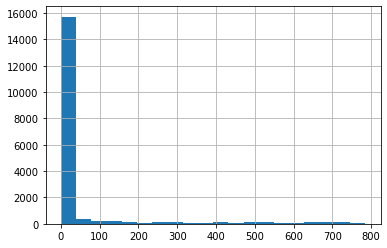

In [9]:
num_ess = prEss.sum()
num_ess.hist( bins=20 )

In [10]:
low_thresh = 0.01
hi_thresh  = 0.80

too_low = where( num_ess<(low_thresh * numSamples) )[0]
prEss.drop( prEss.columns[too_low], axis=1, inplace=True)

num_ess = prEss.sum()

too_high = where( num_ess>(hi_thresh * numSamples) )[0]
prEss.drop( prEss.columns[too_high], axis=1, inplace=True)

prEss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 808 entries, ACH-001172 to ACH-002510
Columns: 2987 entries, AAAS to ZZZ3
dtypes: bool(2987)
memory usage: 2.3+ MB


# Do regression across all prEss columns

In [11]:
coeffs = pd.DataFrame(columns=prEss.columns.values, index=list(features.columns.values) + ['intercept'], dtype=float)
regr = linear_model.LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.25, max_iter=2500)

In [12]:
#
# cast regression calc as a function
#
def do_regression(g):
    regr.fit(features, prEss[g])
    coeffs[g] = np.append( regr.coef_, regr.intercept_).T

In [ ]:
#
# executor = multithreader.
#
start = time.time()
executor = concurrent.futures.ThreadPoolExecutor(32) # number of threads = 12

futures = [executor.submit(do_regression, g) for g in prEss.columns.values]

errstate = concurrent.futures.wait(futures)
end = time.time()

/home/traver/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [17]:
print("Execution time:")
print( end - start)
#
#Execution time:
#5573.109220027924
# 0r 92 minutes on 12 threads with max 500 iter/regression and a LOT of "did not converge" warnings
#
#Execution time:
# 1842.9349806308746
# or 30.7 min on 32 threads. 3x faster!!!
#
# 2500 iter/regression
# 4660 sec (77 min)
# repeat at base clock speed for CPU, RAM: 4668 sec

Execution time:
4668.462904930115


In [18]:
def unpivot(frame):
    N, K = frame.shape
    data = {'coeff': frame.to_numpy().ravel('F'),
            'Gene': np.asarray(frame.columns).repeat(N),
            'Feature': np.tile(np.asarray(frame.index), K)}
    return pd.DataFrame(data, columns=['Feature', 'Gene', 'coeff'])

In [19]:
coeffs_list = unpivot(coeffs)

In [20]:
coeffs_list.sort_values('coeff', ascending=False, inplace=True)
coeffs_list.drop( coeffs_list[ coeffs_list.Feature=='intercept'].index, axis=0, inplace=True)

In [21]:
coeffs_list.head(10)

,Feature,Gene,coeff
4886516,NRAS_GOF,NRAS,4.916765
3555442,KRAS_GOF,KRAS,4.614621
627649,BRAF_GOF,BRAF,4.135042
3351020,peripheral_nervous_system,ISL1,3.600979
4451483,peripheral_nervous_system,MYCN,3.507349
3327660,plasma_cell,IRF4,3.375038
6999783,melanoma,SOX10,3.190437
4442732,blood,MYB,3.170933
5373879,plasma_cell,PIM2,3.127246
7159802,STAG2_LOF,STAG1,3.104188


In [22]:
coeffs_list.tail(10)

,Feature,Gene,coeff
5584187,TP53_GOF,PPM1D,-1.969958
2828621,NRAS_GOF,GRB2,-1.973878
871971,RB1_LOF,CCND1,-2.052547
3359767,CDH_VIM_lo,ITGA3,-2.132578
3893600,TP53_LOF,MDM4,-2.197559
2828575,BRAF_GOF,GRB2,-2.291603
487481,peripheral_nervous_system,ATP6V1G1,-2.292867
3891167,TP53_GOF,MDM4,-2.348442
3890681,TP53_LOF,MDM2,-3.582439
3888248,TP53_GOF,MDM2,-3.636815


In [23]:
failed = isnan( coeffs_list.coeff)
sum(failed)

0

In [24]:
coeffs_list.shape

(8716066, 3)

<AxesSubplot:>

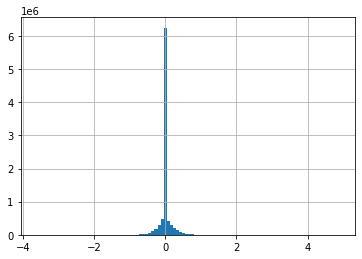

In [27]:
coeffs_list.coeff.hist(bins=100)

In [28]:
coeffs.to_csv('./Data/coefficients-logReg-matrix-elastic-point25-2918feats-2987genes-Avana20q4.txt', sep='\t', float_format='%4.3f', index=True)

In [29]:
coeffs_list.to_csv('./Data/coefficients-logReg-list-elastic-point25-2918feats-2987genes-Avana20q4.txt', sep='\t', float_format='%4.3f', index=False)
